## 基础的模型：广义帕累托分布。对于99分位数以后使用重采样的结果。基本可以得到fair fit以上

适合的测序方法：(绝大部分)
- 10x Visium
- Xenium(不是很好)
- Stereo-seq
- Vsium HD(非常好)
- seqFish
- Slide-V2

并且发现，单细胞测序的方差也能使用这个模型拟合：
- 10x Genomics scRNA-seq
- 10X Multiome Gene Expression and Chromatin Accessability

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
# adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


## 对长尾高值部分的，直接等值。基本可以得到excellent fit的结果

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
# adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")
sc.pp.filter_genes(adata, min_cells=5)

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = tail_data
# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


In [60]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def evaluate_fit(original, generated, quantiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    def cohens_d(x1, x2):
        n1, n2 = len(x1), len(x2)
        var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_se

    def relative_error(x1, x2):
        return np.abs(np.mean(x1) - np.mean(x2)) / np.mean(x1)

    # 计算主要指标
    effect_size = cohens_d(original, generated)
    rel_error = relative_error(original, generated)
    ks_stat, _ = ks_2samp(original, generated)
    correlation = np.corrcoef(np.sort(original), np.sort(generated))[0, 1]

    # 计算分位数相对误差
    orig_quant = np.quantile(original, quantiles)
    gen_quant = np.quantile(generated, quantiles)
    quant_rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

    # 评估结果
    results = {
        "Cohen's d": effect_size,
        "Relative Error": rel_error,
        "KS Statistic": ks_stat,
        "Correlation": correlation,
        "Quantile Relative Errors": dict(zip([f"{q*100}th" for q in quantiles], quant_rel_errors))
    }

    # 修改判定标准
    excellent = (abs(effect_size) < 0.05 and rel_error < 0.05 and ks_stat < 0.1 and correlation > 0.95
                )

    good = (abs(effect_size) < 0.1 and rel_error < 0.15 and ks_stat < 0.15 and correlation > 0.9 
            )

    fair = (abs(effect_size) < 0.2 and rel_error < 0.2 and ks_stat < 0.2 and correlation > 0.8 
            )



    if excellent:
        verdict = "Excellent fit"
    elif good:
        verdict = "Good fit"
    elif fair:
        verdict = "Fair fit"
    else:
        verdict = "Poor fit"

    results["Verdict"] = verdict

    # 可视化（使用对数刻度）
    plt.figure(figsize=(15, 5))

    # 密度图比较
    plt.subplot(131)
    kde_orig = gaussian_kde(np.log1p(original))
    kde_gen = gaussian_kde(np.log1p(generated))
    x_range = np.linspace(np.min(np.log1p(original)), np.max(np.log1p(original)), 1000)
    plt.plot(x_range, kde_orig(x_range), label='Original')
    plt.plot(x_range, kde_gen(x_range), label='Generated')
    plt.title('Density Comparison (Log Scale)')
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('Density')
    plt.legend()

    # Q-Q图（对数刻度）
    plt.subplot(132)
    plt.scatter(np.log1p(np.sort(original)), np.log1p(np.sort(generated)), alpha=0.5)
    plt.plot([np.log1p(min(original)), np.log1p(max(original))], 
             [np.log1p(min(original)), np.log1p(max(original))], 'r--')
    plt.xlabel('Original Quantiles (Log Scale)')
    plt.ylabel('Generated Quantiles (Log Scale)')
    plt.title('Q-Q Plot (Log Scale)')

    # ECDF（对数刻度）
    plt.subplot(133)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return x, y
    x_orig, y_orig = ecdf(original)
    x_gen, y_gen = ecdf(generated)
    plt.step(np.log1p(x_orig), y_orig, where='post', label='Original', alpha=0.7)
    plt.step(np.log1p(x_gen), y_gen, where='post', label='Generated', alpha=0.7)
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function (Log Scale)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# 使用函数
evaluation = evaluate_fit(gene_variances, new_samples)

# 打印结果
for key, value in evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10629 and the array at index 1 has size 10778

## 第二个特殊的混合模型：对数正态分布
比如Merfish等，并没有很多dropout的结果，不适合用广义帕累托分布进行拟合。反而，使用对数正态分布效果很好

适合的模型：
- Merfish
- 

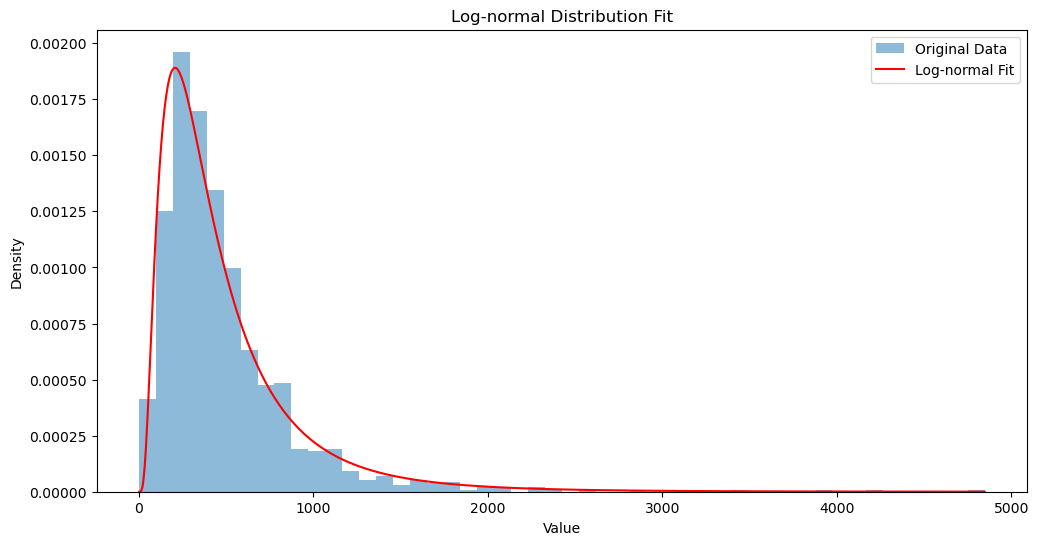

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import scanpy as sc
import scipy.sparse as sp

def calc_var(X, axis=0):
    return np.var(X, axis=axis)

def fit_lognormal(data):
    log_data = np.log(data)
    mu = np.mean(log_data)
    sigma = np.std(log_data)
    return sigma, 0, np.exp(mu)

def generate_lognormal_samples(params, n_samples):
    sigma, loc, scale = params
    return lognorm.rvs(s=sigma, loc=loc, scale=scale, size=n_samples)

def plot_distribution(data, params):
    plt.figure(figsize=(12, 6))
    
    # 绘制原始数据直方图
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original Data')
    
    # 生成用于绘制的x值
    x = np.linspace(min(data), max(data), 1000)
    
    # 绘制对数正态分布曲线
    sigma, loc, scale = params
    y_lognorm = lognorm.pdf(x, s=sigma, scale=scale)
    plt.plot(x, y_lognorm, 'r-', label='Log-normal Fit')
    
    plt.legend()
    plt.title('Log-normal Distribution Fit')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

# # 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/merfish_adata.h5ad")
# 如果adata.X是稀疏矩阵，请转换为密集矩阵
if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算基因方差
gene_variances = calc_var(adata.X)

# 拟合对数正态分布
lognormal_params = fit_lognormal(gene_variances)

# 生成样本
lognormal_samples = generate_lognormal_samples(lognormal_params, n_samples=1000)

# 可视化对数正态分布拟合
plot_distribution(gene_variances, lognormal_params)


# 测试单细胞测序

In [145]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [146]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [148]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

sample
s1d1    8785
Name: count, dtype: int64


/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8785 × 36601
    obs: 'sample'

In [149]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [150]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [159]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [153]:
adata.X

<8713x21675 sparse matrix of type '<class 'numpy.float32'>'
	with 14066479 stored elements in Compressed Sparse Row format>

In [124]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [125]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## 绘制mean和var之间的关系

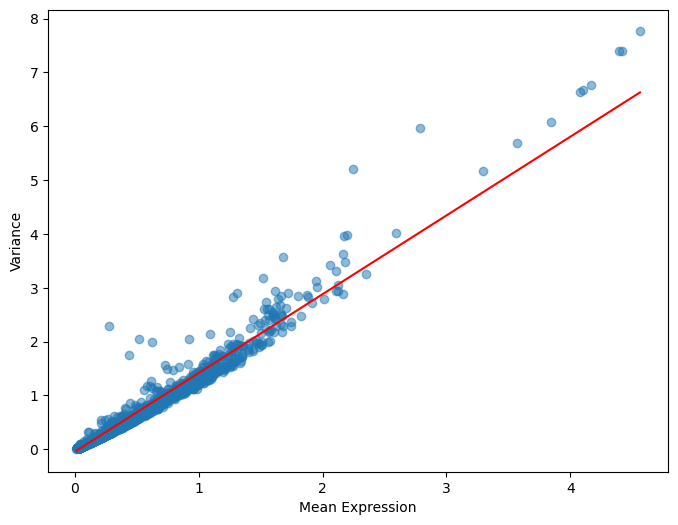

0.9671306813153738


In [5]:

adata = sc.read_h5ad("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151675.h5ad")
sc.pp.filter_genes(adata, min_cells=5)
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)
adata.X = adata.X.A
# 计算基因方差
gene_variances = calc_var(adata.X)
#计算mean
def calc_mean(X, axis=0):
    return np.mean(X, axis=axis)
gene_means = calc_mean(adata.X)

gene_means = np.log1p(gene_means)
gene_variances = np.log1p(gene_variances)

# 拟合线性模型并检查
import statsmodels.api as sm

# 添加截距项
X = sm.add_constant(gene_means)

# 拟合线性模型
model = sm.OLS(gene_variances, X)

# 拟合模型
results = model.fit()

# 提取参数
intercept, slope = results.params

# 绘制拟合结果
plt.figure(figsize=(8, 6))

# 绘制原始数据

plt.scatter(gene_means, gene_variances, alpha=0.5, label='Original Data')

# 绘制拟合线

x_range = np.linspace(min(gene_means), max(gene_means), 1000)
plt.plot(x_range, slope * x_range + intercept, 'r-', label='Fitted Line')

plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.show()
# 检验拟合结果，计算R方
R_sqr = results.rsquared

print(R_sqr)

In [31]:
# 计算基因在spot中的零比例
def calc_zero_proportion(X):
    return np.mean(X == 0, axis=0)

zero_proportion = calc_zero_proportion(adata.X)
zero_proportion = 1- zero_proportion

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
# adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A


# 分割数据
main_data = zero_proportion

import numpy as np
from scipy.stats import genpareto

def transform_data(data, epsilon=1e-10):
    # 将 [0, 1] 映射到 [0, +∞)
    return -np.log(1 - np.clip(data, 0, 1-epsilon))

def inverse_transform(data):
    # 将 [0, +∞) 映射回 [0, 1]
    return 1 - np.exp(-data)

def fit_extended_gpd(data, n_virtual_points=200, max_virtual_value=10):
    transformed_data = transform_data(data)
    
    # 添加虚拟点
    virtual_points = np.linspace(np.max(transformed_data), max_virtual_value, n_virtual_points)
    extended_data = np.concatenate([transformed_data, virtual_points])
    
    # 拟合 GPD
    shape, loc, scale = genpareto.fit(extended_data)
    
    return shape, loc, scale

def sample_extended_gpd(shape, loc, scale, size):
    # 生成样本
    samples = genpareto.rvs(shape, loc, scale, size=size)
    
    # 将样本映射回 [0, 1] 区间
    return inverse_transform(samples)

# 拟合模型
shape, loc, scale = fit_extended_gpd(main_data, n_virtual_points=100, max_virtual_value=10)

# 生成新样本
new_samples = sample_extended_gpd(shape, loc, scale, size=len(main_data))

# 将新样本限制在 [0, 1] 范围内
new_samples = np.clip(new_samples, 0, 1)

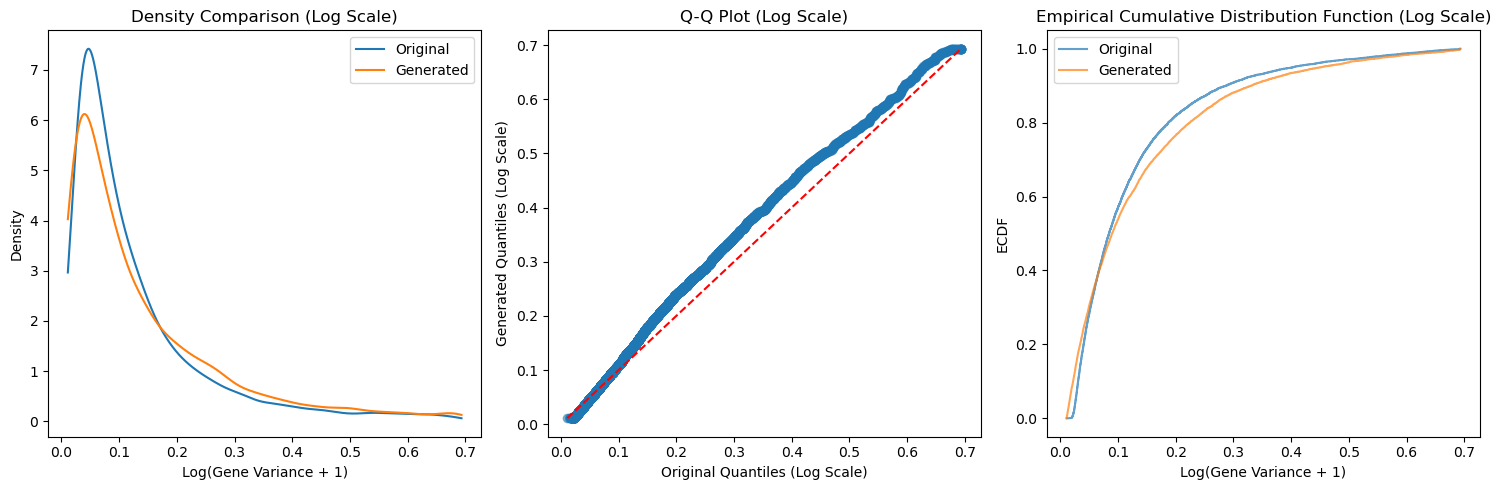

Cohen's d: -0.09166884311935847
Relative Error: 0.10849374609409393
KS Statistic: 0.09568162574089754
Correlation: 0.9966525580928537
Quantile Relative Errors:
  25.0th: 0.1019
  50.0th: 0.0654
  75.0th: 0.2173
  90.0th: 0.1760
  95.0th: 0.1503
  99.0th: 0.0691
Verdict: Good fit


In [44]:
# 使用函数
evaluation = evaluate_fit(main_data, new_samples)

# 打印结果
for key, value in evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp

# 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")
sc.pp.filter_genes(adata, min_cells=5)

if sp.issparse(adata.X):
    adata.X = adata.X.A

# 计算每个基因的平均表达量
gene_means = np.mean(adata.X, axis=0)

# 设定阈值，例如使用99百分位数
threshold = np.percentile(gene_means, 99)

# 分割数据
main_data = gene_means[gene_means <= threshold]
tail_data = gene_means[gene_means > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_means), np.max(gene_means))

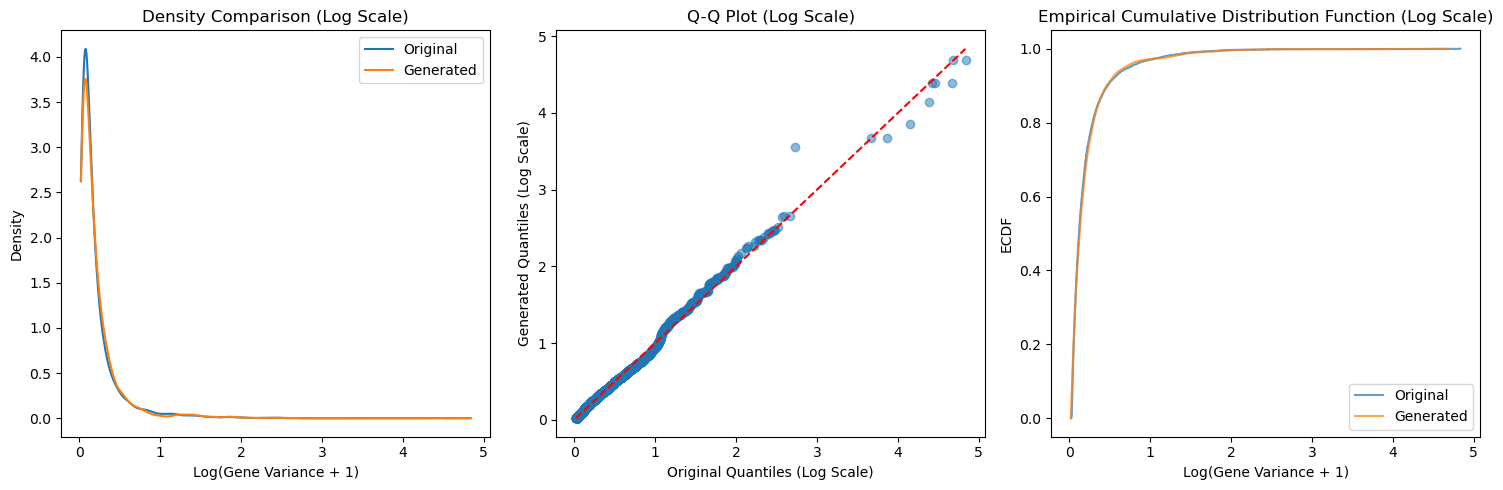

Cohen's d: 0.00041519830885655077
Relative Error: 0.0026850127364530544
KS Statistic: 0.06067916125440713
Correlation: 0.989543579308102
Quantile Relative Errors:
  25.0th: 0.0213
  50.0th: 0.0658
  75.0th: 0.0668
  90.0th: 0.0338
  95.0th: 0.1046
  99.0th: 0.0475
Verdict: Excellent fit


In [58]:
# 使用函数
evaluation = evaluate_fit(gene_means, new_samples)

# 打印结果
for key, value in evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

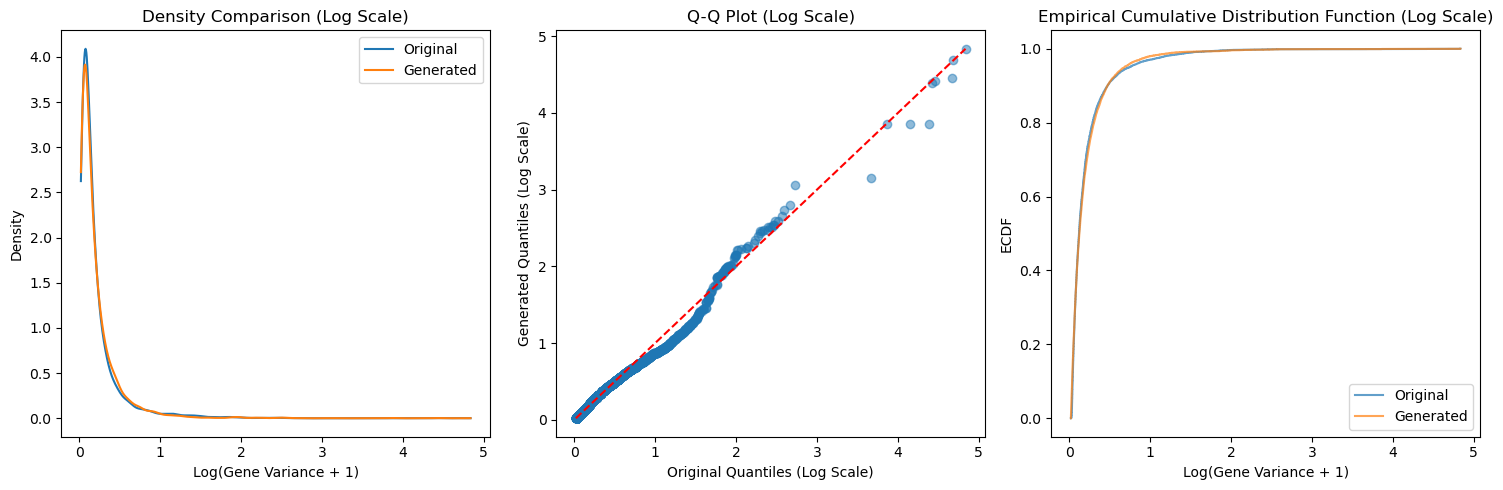

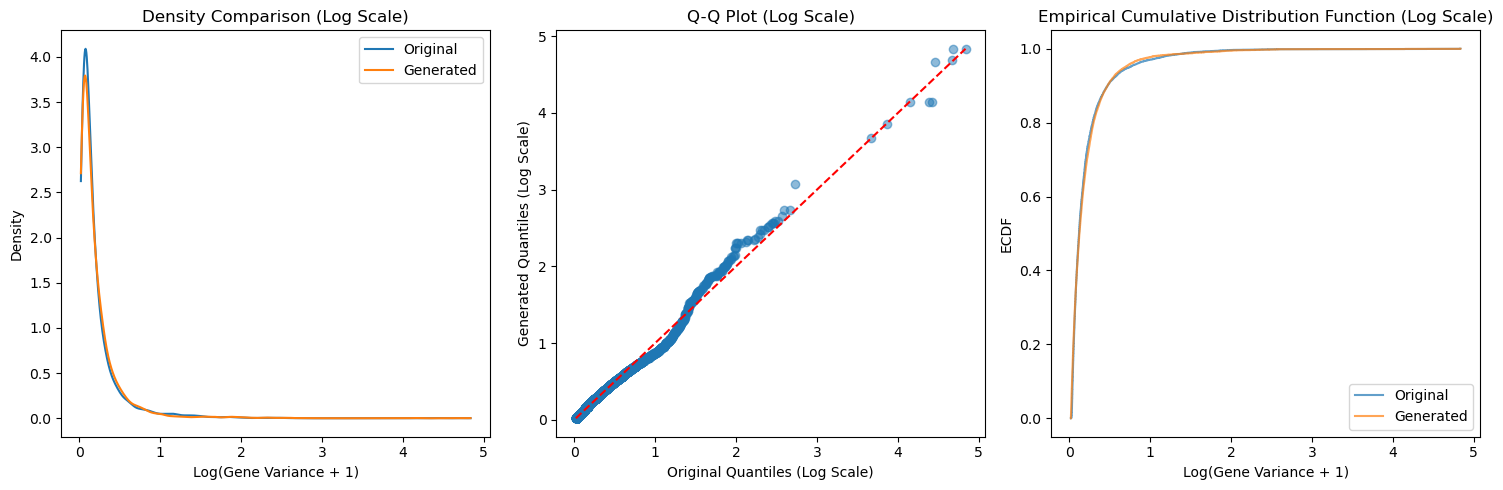

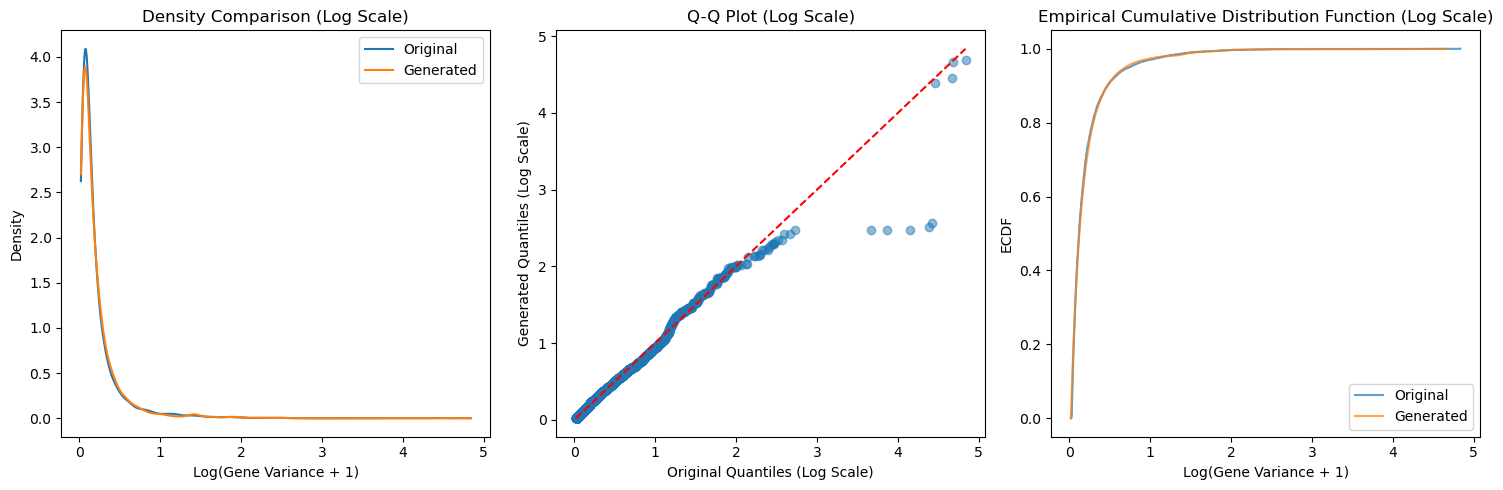

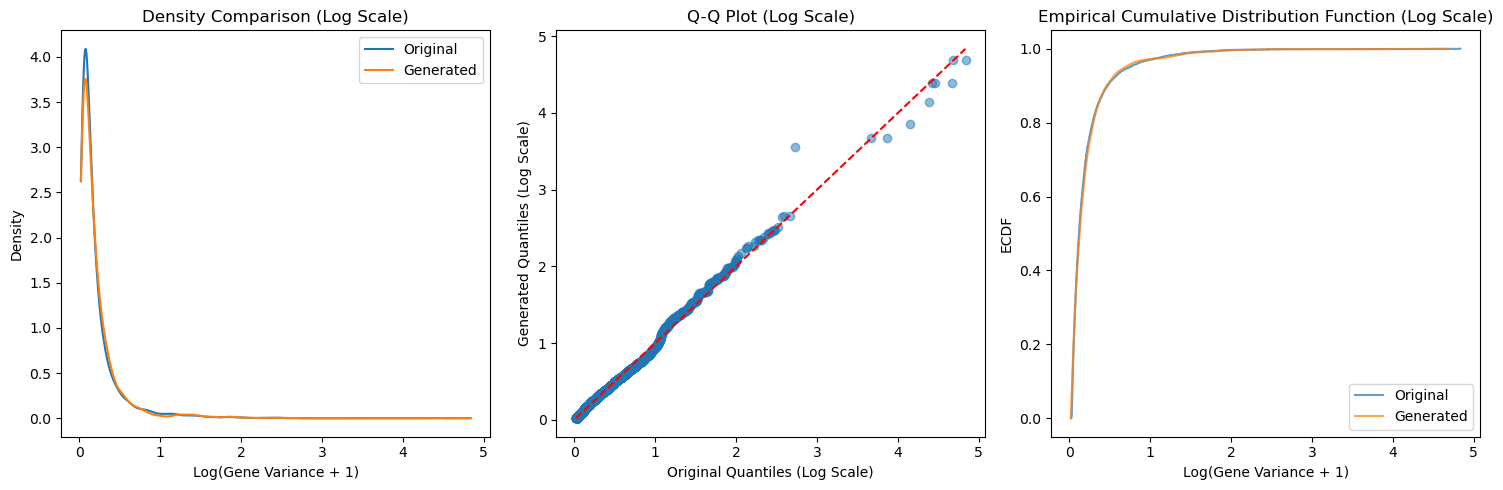

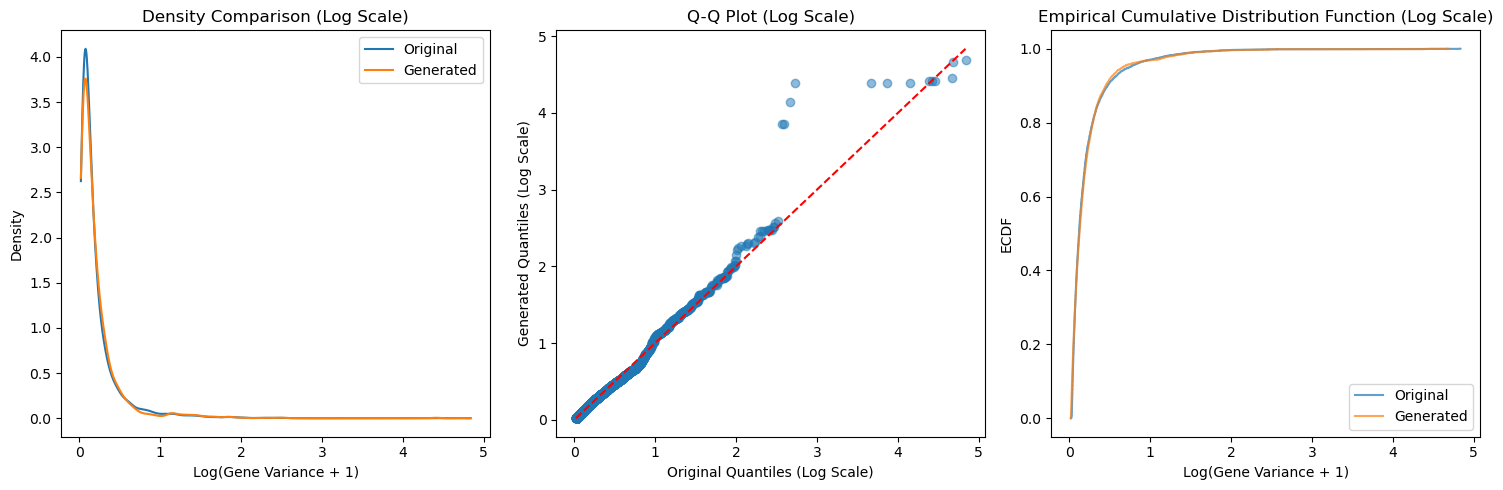

In [57]:
from scipy.stats import ks_2samp

def genpareto_fit_mean(filtered_adata, mode="strict", threshold=None):
    if sp.issparse(filtered_adata.X):
        filtered_adata.X = filtered_adata.X.A

    gene_means = np.mean(filtered_adata.X, axis=0)

    if mode == "strict":
        thresholds = [99.5, 99, 98.5, 98, 97.5]
        best_score = float('inf')
        best_threshold = None
        best_samples = None

        for percentile in thresholds:
            current_threshold = np.percentile(gene_means, percentile)
            main_data = gene_means[gene_means <= current_threshold]
            tail_data = gene_means[gene_means > current_threshold]

            shape, loc, scale = genpareto.fit(main_data)

            n_main = len(main_data)
            n_tail = len(tail_data)

            new_main = genpareto.rvs(shape, loc, scale, size=n_main)
            new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

            new_samples = np.concatenate([new_main, new_tail])
            new_samples = np.clip(new_samples, np.min(gene_means), np.max(gene_means))

            # 评估拟合效果
            evaluation = evaluate_fit(gene_means, new_samples)
            
            # 计算一个综合得分（这里您可以根据需要调整权重）
            score = (abs(evaluation["Cohen's d"]) + 
                     evaluation["Relative Error"] + 
                     evaluation["KS Statistic"] + 
                     (1 - evaluation["Correlation"]))

            if score < best_score:
                best_score = score
                best_threshold = current_threshold
                best_samples = new_samples

        return best_samples

    else:
        threshold = np.percentile(gene_means, 99)
        main_data = gene_means[gene_means <= threshold]
        tail_data = gene_means[gene_means > threshold]

        shape, loc, scale = genpareto.fit(main_data)

        n_main = len(main_data)
        n_tail = len(tail_data)

        new_main = genpareto.rvs(shape, loc, scale, size=n_main)
        new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

        new_samples = np.concatenate([new_main, new_tail])
        new_samples = np.clip(new_samples, np.min(gene_means), np.max(gene_means))

        return new_samples
    
new_samples = genpareto_fit_mean(adata, mode="strict")

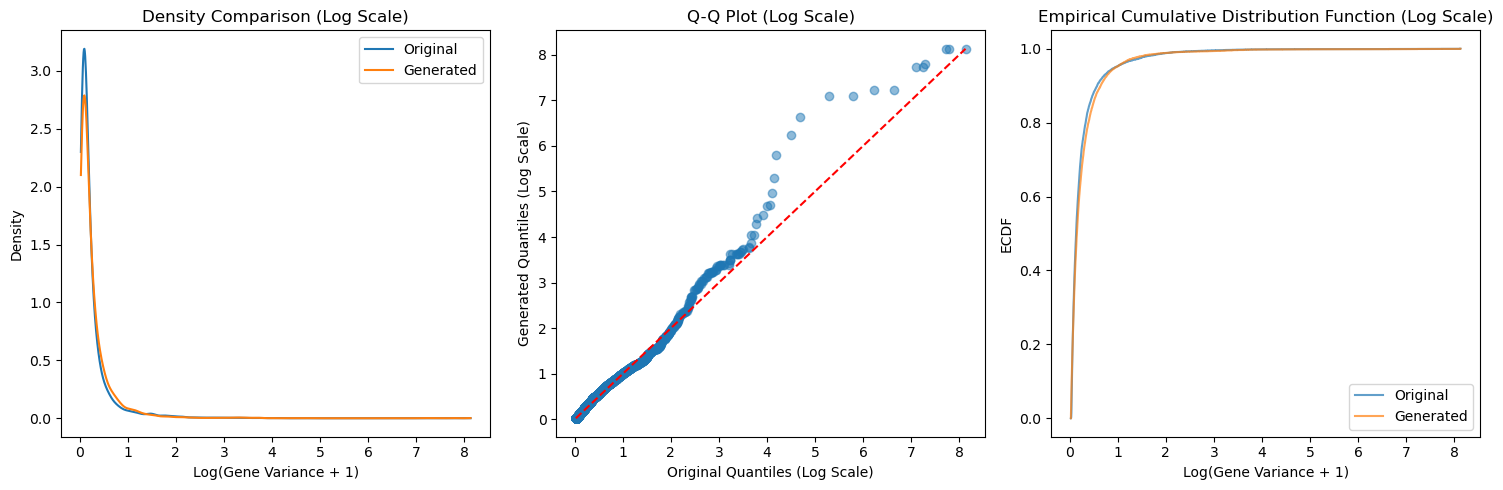

{"Cohen's d": -0.015775720369335354, 'Relative Error': 0.552489258250184, 'KS Statistic': 0.05687511597699024, 'Correlation': 0.9562121630507632, 'Quantile Relative Errors': {'25.0th': 0.031242748596248905, '50.0th': 0.1362618398108219, '75.0th': 0.23281172288414123, '90.0th': 0.17478866349763175, '95.0th': 0.021571577820244436, '99.0th': 0.008952387318914198}, 'Verdict': 'Poor fit'}


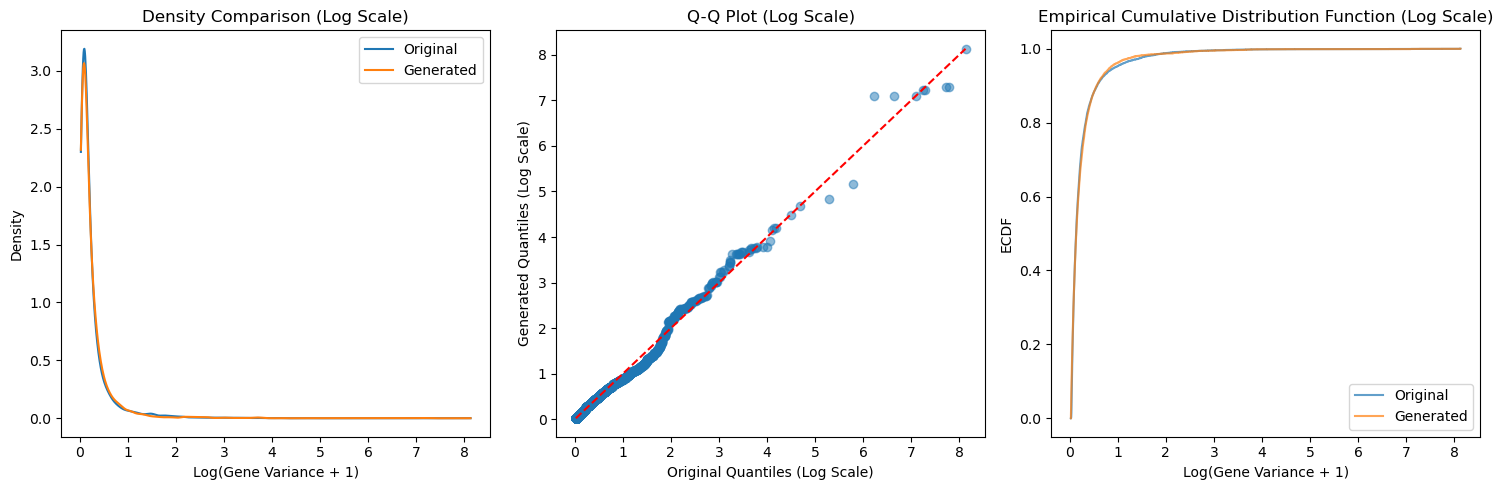

{"Cohen's d": 0.0017644043178047355, 'Relative Error': 0.048107723199928384, 'KS Statistic': 0.06234922991278531, 'Correlation': 0.9602765685690735, 'Quantile Relative Errors': {'25.0th': 0.05098374347421964, '50.0th': 0.027902473093872848, '75.0th': 0.07771488552051616, '90.0th': 0.027526641838508968, '95.0th': 0.14701159672022013, '99.0th': 0.20611930372103507}, 'Verdict': 'Excellent fit'}


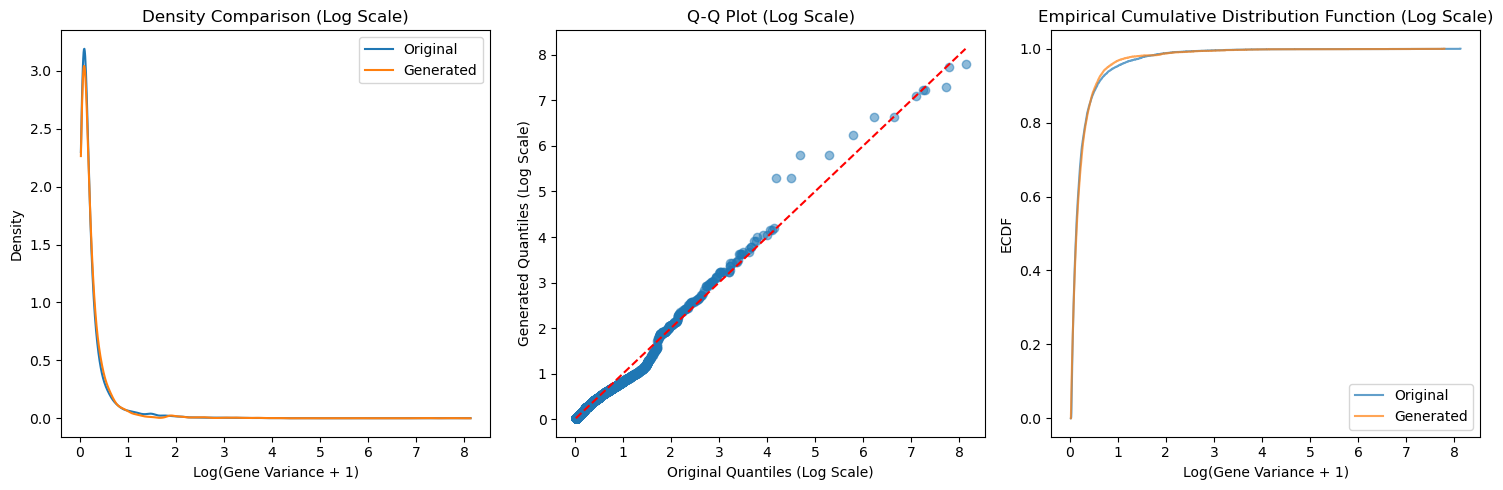

{"Cohen's d": 0.0019442019649309476, 'Relative Error': 0.051089163331754076, 'KS Statistic': 0.05910187418816107, 'Correlation': 0.978861399852675, 'Quantile Relative Errors': {'25.0th': 0.012538742827471314, '50.0th': 0.05817294334190083, '75.0th': 0.054513131937912844, '90.0th': 0.07530257618622761, '95.0th': 0.23770203694869566, '99.0th': 0.04486403104330427}, 'Verdict': 'Good fit'}


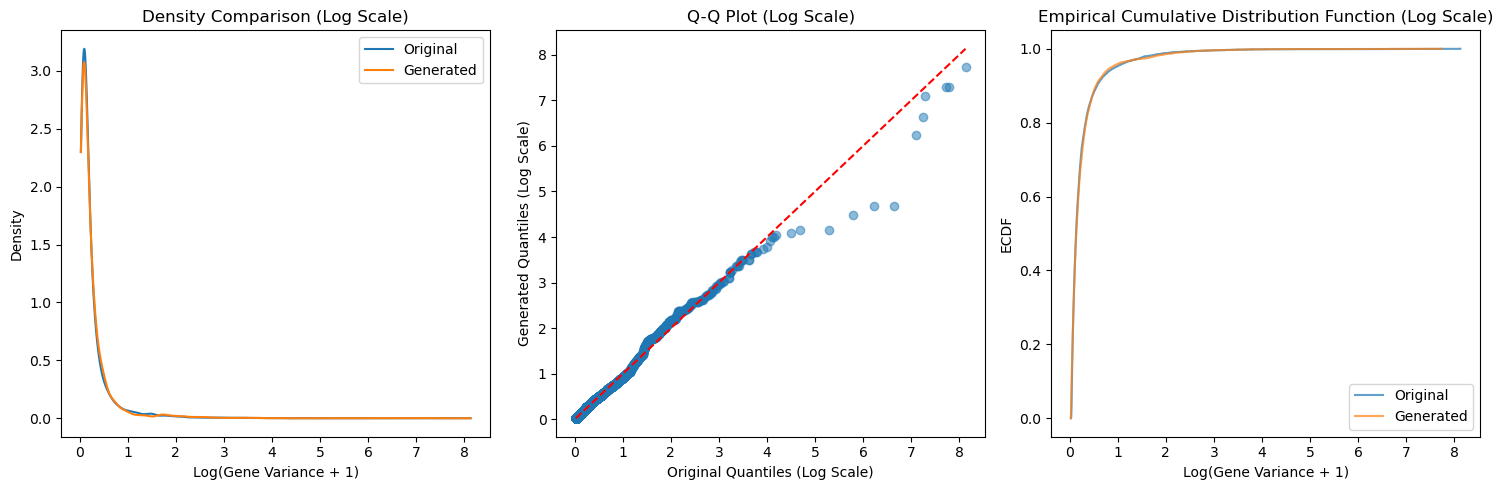

{"Cohen's d": 0.01261781875876153, 'Relative Error': 0.3018510427426993, 'KS Statistic': 0.0530710706995732, 'Correlation': 0.9832422407068222, 'Quantile Relative Errors': {'25.0th': 0.026355491600753338, '50.0th': 0.02252963757260878, '75.0th': 0.06699249857573343, '90.0th': 0.05523240887527356, '95.0th': 0.11606907471767777, '99.0th': 0.1703885490331544}, 'Verdict': 'Poor fit'}


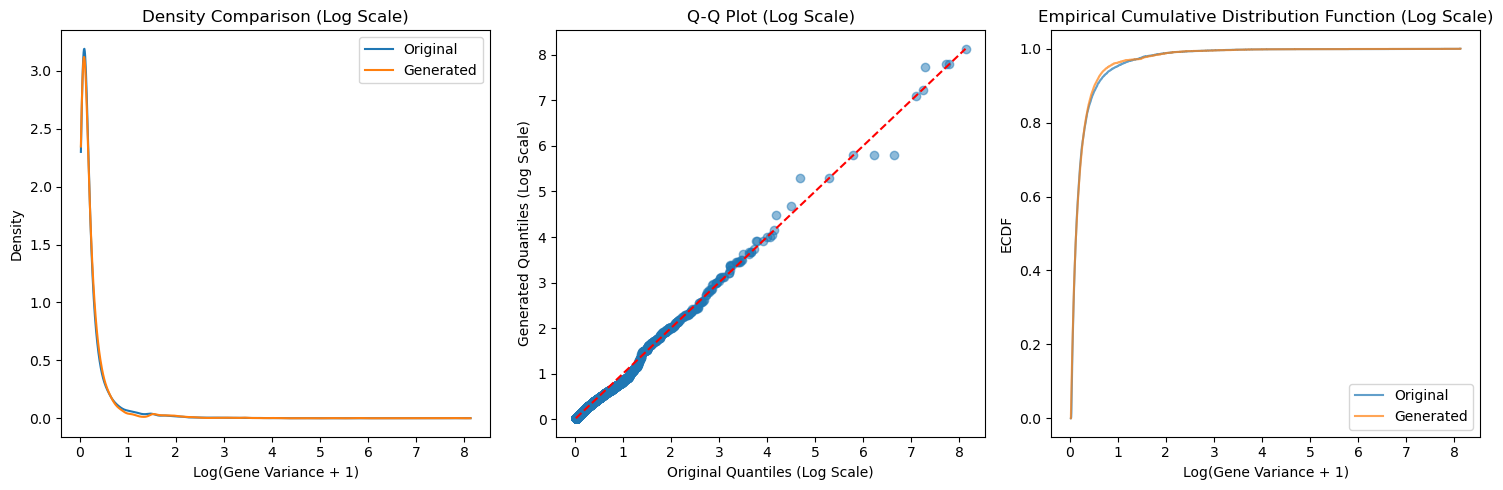

{"Cohen's d": -0.0005731742047756191, 'Relative Error': 0.01680068866553822, 'KS Statistic': 0.057988495082575614, 'Correlation': 0.9861670544623983, 'Quantile Relative Errors': {'25.0th': 0.04297636951796768, '50.0th': 0.004753337768151676, '75.0th': 0.011272655342538981, '90.0th': 0.12699748955374743, '95.0th': 0.23775849320971415, '99.0th': 0.011364579135747812}, 'Verdict': 'Excellent fit'}


In [62]:
import numpy as np
import scipy.sparse as sp
from scipy.stats import genpareto, ks_2samp

def genpareto_fit_var(filtered_adata, mode="strict"):
    if sp.issparse(filtered_adata.X):
        filtered_adata.X = filtered_adata.X.A

    # 计算基因方差
    gene_vars = np.var(filtered_adata.X, axis=0, ddof=1)  # 使用无偏估计

    if mode == "strict":
        thresholds = [99.5, 99, 98.5, 98, 97.5]
        best_score = float('inf')
        best_threshold = None
        best_samples = None

        for percentile in thresholds:
            current_threshold = np.percentile(gene_vars, percentile)
            main_data = gene_vars[gene_vars <= current_threshold]
            tail_data = gene_vars[gene_vars > current_threshold]

            # 直接对主体部分进行拟合
            shape, loc, scale = genpareto.fit(main_data)

            n_main = len(main_data)
            n_tail = len(tail_data)

            # 生成新样本
            new_main = genpareto.rvs(shape, loc, scale, size=n_main)
            new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

            new_samples = np.concatenate([new_main, new_tail])
            new_samples = np.clip(new_samples, np.min(gene_vars), np.max(gene_vars))

            # 评估拟合效果
            evaluation = evaluate_fit(gene_vars, new_samples)
            print(evaluation)
            # 计算综合得分
            score = (abs(evaluation["Cohen's d"]) + 
                     evaluation["Relative Error"] + 
                     evaluation["KS Statistic"] + 
                     (1 - evaluation["Correlation"]))

            if score < best_score:
                best_score = score
                best_threshold = current_threshold
                best_samples = new_samples

        return best_samples, best_threshold

    else:
        threshold = np.percentile(gene_vars, 99)
        main_data = gene_vars[gene_vars <= threshold]
        tail_data = gene_vars[gene_vars > threshold]

        # 直接对主体部分进行拟合
        shape, loc, scale = genpareto.fit(main_data)

        n_main = len(main_data)
        n_tail = len(tail_data)

        # 生成新样本
        new_main = genpareto.rvs(shape, loc, scale, size=n_main)
        new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

        new_samples = np.concatenate([new_main, new_tail])
        new_samples = np.clip(new_samples, np.min(gene_vars), np.max(gene_vars))

        return new_samples, threshold


new_samples, threshold = genpareto_fit_var(adata, mode="strict")